In [31]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install seaborn statsmodels brian2 spykes

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pip in /gpfs/home/gmorto/.local/lib/python3.8/site-packages (20.2.2)
Defaulting to user installation because normal site-packages is not writeable
Using legacy 'setup.py install' for spykes, since package 'wheel' is not installed.
    Running setup.py install for spykes ... done


In [24]:
import os
import sys
import numpy as np
import pandas as pd
PATH = '../../'
sys.path.append(f'{PATH}')
sys.path.append(f'{PATH}/npx_utils')
sys.path.append(f'{PATH}/neb_utils')
import readSGLX
import seaborn as sns
from pathlib import Path
from scipy.signal import savgol_filter
import npx_utils.post_sort_proc as postproc
from npx_utils.data import get_ni_analog,get_tvec,create_spike_dict
%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2 

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
?os.path.relpath

Signature: os.path.relpath(path, start=None)
Docstring: Return a relative version of a path
File:      /depot/apps/python/3.8.0/lib/python3.8/posixpath.py
Type:      function


In [75]:
PATH = '/active/ramirez_j/ramirezlab/nbush/projects'
run_path = f'{PATH}/dynaresp/data/processed/m2020-12/m202012_g11'
imec_path = f'{run_path}/m202012_g11_imec0'
ni_fn = f'{run_path}/m202012_g11_t0.nidq.bin'
sync_ts = np.loadtxt(f'{imec_path}/m202012_g11_tcat.imec0.SY_384_6_500.txt')
resp_chan = 1


In [76]:
sample_rate = 3.000032e+04


In [77]:
p_save = '/active/ramirez_j/ramirezlab/nbush/projects/dynaresp/results/2020-08-21-npx-sc-analysis'

In [78]:
st = np.load(os.path.join(imec_path,'spike_times_sec.npy'))
sc = np.load(os.path.join(imec_path,'spike_clusters.npy'))

In [12]:
meta=readSGLX.readMeta(Path(ni_fn))
ni_dat = readSGLX.makeMemMapRaw(ni_fn,meta)
resp = get_ni_analog(ni_fn,1)
sync_chan = get_ni_analog(ni_fn,0)
ni_sr = readSGLX.SampRate(meta)
tvec = get_tvec(sync_chan,sync_ts,ni_sr)

nChan: 9, nFileSamp: 2679994
nChan: 9, nFileSamp: 2679994
nChan: 9, nFileSamp: 2679994


### Look at nasal trace

In [13]:
resp_smooth = savgol_filter(resp,501,1)


(10.0, 12.0)

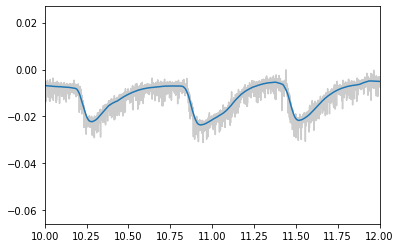

In [14]:
plt.plot(tvec,resp,'k',alpha=.2)
plt.plot(tvec,resp_smooth)
plt.xlim(10,12)


In [15]:
phi = postproc.nasal_to_phase(resp_smooth- np.mean(resp_smooth))
insp = postproc.get_insp_onset(resp_smooth,direction=-1,thresh=2)
insp_sec = tvec[insp]

In [16]:
phi_s = postproc.shift_phi(phi,insp)

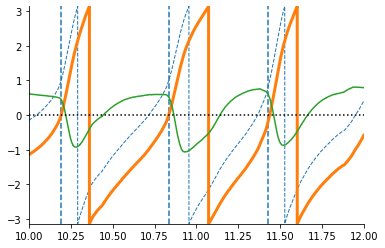

In [17]:
plt.plot(tvec,phi,lw=1,ls='--')
plt.plot(tvec,phi_s,lw=3)
plt.plot(tvec,(resp_smooth-np.mean(resp_smooth))*100)
plt.axhline(0,color='k',ls=':')
plt.vlines(insp_sec,-np.pi,np.pi,ls='--')
plt.xlim(10,12)
plt.ylim(-np.pi,np.pi)
sns.despine();

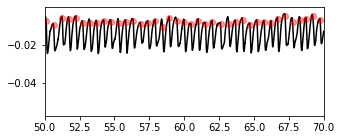

In [18]:
# plt.plot(tvec[2:],-np.diff(savgol_filter(np.diff(resp_smooth),501,1)))
f = plt.figure(figsize=(5,2))
plt.plot(tvec,resp_smooth,'k')
plt.plot(insp_sec,resp_smooth[insp],'ro',alpha=0.4)
plt.xlim(50,70)
plt.savefig(os.path.join(p_save,'resp_trace_detect.png'),dpi=300)


### Load spikes and inspect

In [19]:
spike_dict = create_spike_dict(imec_path)

In [20]:
df = pd.DataFrame.from_dict(spike_dict,orient='index')
df.index.name='cluster'
df_good = df[df.label=='good'].sort_values('depth')
df_good.reset_index()

,cluster,ts,amp,label,pk_channel,depth,n_spikes,mean_amp
0,0,"[0.08383243912064937, 0.1763981184200702, 0.18...","[22.22412872314453, 22.69145393371582, 21.6487...",good,8,80.0,2465,20.738308
1,1,"[0.10896550436795341, 0.38222925622126697, 0.6...","[30.897451400756836, 32.065853118896484, 33.22...",good,14,140.0,647,32.587220
2,2,"[0.006866593423003488, 0.08076580516474491, 0....","[36.72041320800781, 37.67048263549805, 36.0077...",good,18,180.0,4272,37.469482
3,3,"[0.14926507450587193, 0.32562985994816057, 0.5...","[12.208730697631836, 16.120376586914062, 15.59...",good,18,180.0,1326,14.107504
4,5,"[0.00916656888993184, 0.025066399291740888, 0....","[12.916977882385254, 10.901047706604004, 11.40...",good,26,260.0,14110,13.091803
...,...,...,...,...,...,...,...,...
88,98,"[0.10799884801228787, 0.3269965120372049, 0.70...","[24.377504348754883, 21.337078094482422, 24.02...",good,302,3020.0,1368,23.406336
89,99,"[0.05996602702904502, 0.11856540196904566, 0.1...","[23.408218383789062, 21.87028694152832, 24.329...",good,308,3080.0,3091,23.286446
90,103,"[0.03496629369286727, 0.06499930667406215, 0.1...","[26.980871200561523, 24.398967742919922, 26.42...",good,361,3600.0,7741,25.631858
91,102,"[0.1643649134409233, 0.3015634499898668, 0.435...","[38.82280731201172, 34.30691146850586, 37.8753...",good,361,3600.0,1666,36.538653


## Smoothed Spike Rates as Heatmap

In [25]:
import neb_utils.brian_utils.postproc as bup

In [26]:
raster,cell_id,bins = bup.bin_trains(st*bup.second,sc,len(np.unique(sc)),max_time=tvec[-1]*bup.second,binsize=50*bup.ms);

In [27]:
depth_order = np.argsort(df.depth.values)
depth = np.sort(df.depth.values)

WARNING    <ipython-input-28-41cd5c53c6ec>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(bins,cell_id,raster[depth_order,:],cmap='gray_r')
 [py.warnings]


Text(0, 0.5, 'Neuron ID')

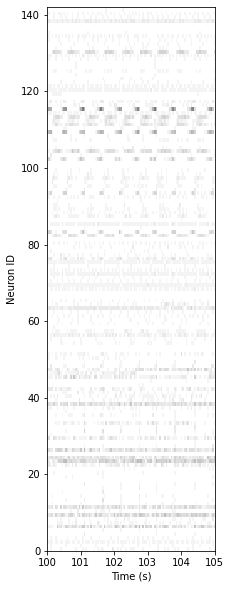

In [28]:
f = plt.figure(figsize=(3,10))
plt.pcolormesh(bins,cell_id,raster[depth_order,:],cmap='gray_r')
plt.xlim(100,105)
plt.xlabel('Time (s)')
plt.ylabel('Neuron ID')

### Smoothed Spike Rates as Traces

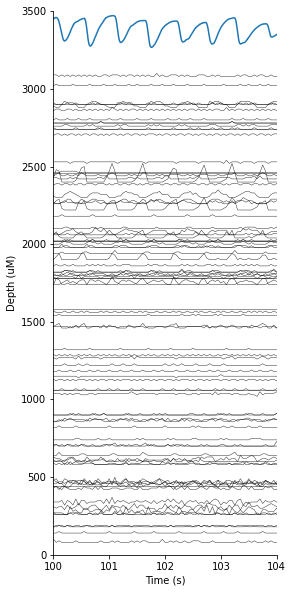

In [29]:

f = plt.figure(figsize=(4,10))

for clu in df_good.index.unique():
    depth = df.iloc[clu]['depth']
    fr = raster[clu,:]
    plt.plot(bins,fr*10+depth,'k',lw=0.5,alpha=0.8)

plt.plot(tvec,resp_smooth*10000+3500)
plt.xlim(100,104)
plt.ylim(0,3500)
plt.ylabel('Depth (uM)')
plt.xlabel('Time (s)')
sns.despine()
plt.savefig(os.path.join(p_save,'population_rates_by_depth.png'),dpi=300)


### Work with Pavan's spykes package to visualize

In [33]:
from spykes.plot.neurovis import NeuroVis
from spykes.plot.popvis import PopVis

In [34]:
neuron_list=  []
for ii in df_good.index:
    ts = df_good.loc[ii]['ts']
    neuron = NeuroVis(ts,name=f'{ii}')
    neuron_list.append(neuron)

In [35]:
pop = PopVis(neuron_list)

#### Align to inspiration time (red line in figure)

In [36]:
data_df = pd.DataFrame()
data_df['insp'] = tvec[insp]

In [37]:
all_psth = pop.get_all_psth(event='insp',df=data_df,binsize=1,window=[-100,250],plot=False)

In [38]:
depth_order = np.argsort(df_good.depth.values)
plt.figure(figsize=(3,5))
pop.plot_heat_map(all_psth,sortby=depth_order,normalize='each')
plt.gca().set_yticklabels([])
plt.title('Ordered by depth\nNormalized FR')
plt.savefig(os.path.join(p_save,'pop_psth.png'),dpi=300)
plt.close('all')

[]

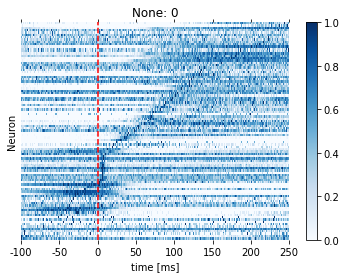

In [39]:
f = pop.plot_heat_map(all_psth,sortby='latency',normalize='each')
plt.gca().set_yticks([])

In [40]:
mod = []
for neuron in neuron_list:
    psth = neuron.get_psth(event='insp',df=data_df,plot=False,binsize=3);
    max_fr = np.max(psth['data'][0]['mean'])
    min_fr = np.min(psth['data'][0]['mean'])
    mean_sem = np.mean(psth['data'][0]['sem'])
    mod.append((max_fr-min_fr)/mean_sem)
mod = np.array(mod)

In [41]:
best_list = np.argsort(mod)[::-1][:15]
worst_list = np.argsort(mod)[::-1][-15:]

### Plot all best

In [42]:
f = plt.figure(figsize=(14,8))
count = 1
for ii in best_list:
    ax = f.add_subplot(4,4,count)
    neuron_list[ii].get_psth(event='insp',df=data_df,binsize=5,window=[-400,400]);
    count+=1
    ax.set_ylim(0,220)
plt.tight_layout()
plt.savefig(os.path.join(p_save,f'best_tuning_mods.png'),dpi=300)
plt.close('all')

### Plot all worst

In [43]:
f = plt.figure(figsize=(14,8))
count = 1
for ii in worst_list:
    ax = f.add_subplot(4,4,count)
    neuron_list[ii].get_psth(event='insp',df=data_df,binsize=5,window=[-400,400]);
    count+=1
    ax.set_ylim(0,220)
plt.tight_layout()
plt.savefig(os.path.join(p_save,f'worst_tuning_mods.png'),dpi=300)
plt.close('all')

### Plot best individual

In [44]:
count = 1
for ii in best_list:
    f = plt.figure()
    neuron_list[ii].get_psth(event='insp',df=data_df,binsize=5,window=[-400,400]);
    plt.savefig(os.path.join(p_save,f'tuning_cuve-mod{mod[ii]:2.0f}-neuron{ii}.png'),dpi=300)
    plt.close('all')

### Plot modulation by depth

In [45]:
depth = df_good['depth'].values

In [46]:

hist,edges = np.histogram(depth,bins=np.arange(0,3500,200),weights=mod)

In [47]:
import seaborn as sns

In [48]:
df2 = pd.DataFrame()
df2['edges'] = edges[1:]
df2['hist'] = hist

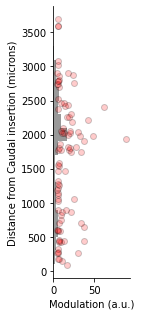

In [49]:
plt.figure(figsize=(2,4.5))
plt.barh(edges[1:],hist/len(hist),height=200,alpha=.4,color='k')
plt.plot(mod,depth,'o',markeredgecolor='k',markerfacecolor='r',alpha=0.2)
sns.despine()
plt.xlabel('Modulation (a.u.)')
plt.ylabel('Distance from Caudal insertion (microns)')
plt.tight_layout()
plt.savefig(os.path.join(p_save,'depth_vs_modulation.png'),dpi=300)



In [50]:
plt.close('all')

### Optotag?

In [51]:
from utils.ephys.signal import binary_onsets
opto = get_ni_analog(ni_fn,3)
light_on,light_off = binary_onsets(opto,1)
light_on = tvec[light_on]
light_of = tvec[light_off]

nChan: 9, nFileSamp: 2679994


#### Align to optic signal

In [52]:
opto_df = pd.DataFrame()
opto_df['light_on'] = light_on

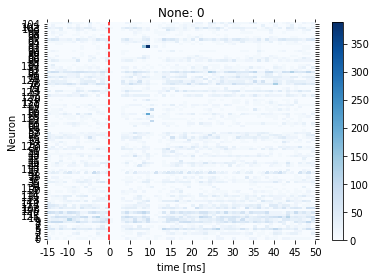

In [53]:
psth = pop.get_all_psth(df=opto_df,event='light_on',window=[-15,50],plot=False,binsize=1);
pop.plot_heat_map(psth)

In [54]:
tagged = np.argmax(np.max(psth['data'][0],1))
print(f'Opto tagged neuron is #{tagged}')

Opto tagged neuron is #82


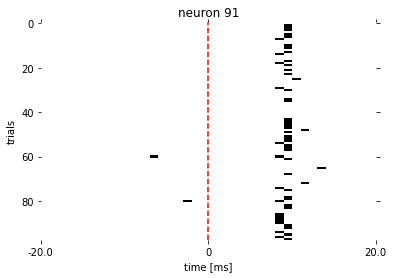

In [55]:
raster = neuron_list[82].get_raster(df= opto_df,event='light_on',window=[-20,20],binsize=1);

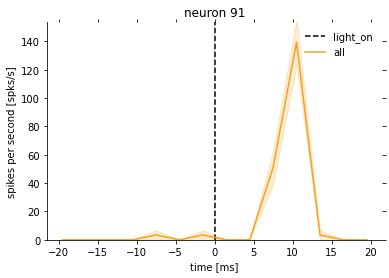

In [56]:
psth = neuron_list[82].get_psth(event='light_on',df=opto_df,binsize=3,window=[-20,20]);

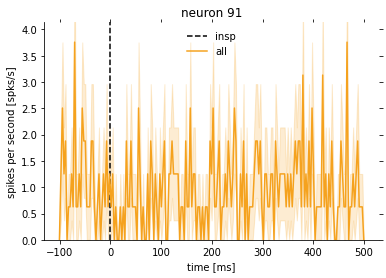

In [57]:
psth = neuron_list[82].get_psth(event='insp',df=data_df,binsize=3);

### Plot by phase

In [58]:
from tqdm import tqdm

In [59]:
all_rate = []
for neuron in tqdm(neuron_list):
    st = neuron.spiketimes

    sp_samp= np.searchsorted(tvec,st)
    sp = np.zeros_like(phi_s)
    sp[sp_samp] = 1
    rate,theta_k,theta,L_dir = postproc.angular_response_hist(phi_s,sp,100)
    all_rate.append(rate)
all_rate = np.array(all_rate)

100%|██████████| 93/93 [00:22<00:00,  4.14it/s]


In [60]:
normed_rate = all_rate.T/np.max(all_rate,1)
normed_rate = normed_rate.T
order = np.argsort(np.argmax(all_rate,1))
order_r = np.argsort(np.argmin(all_rate,1))
# order = np.argsort(df_good.depth)

WARNING    <ipython-input-61-e6731ad0b10b>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(theta_k[:-1],np.arange(len(neuron_list)),normed_rate[order,:],
 [py.warnings]


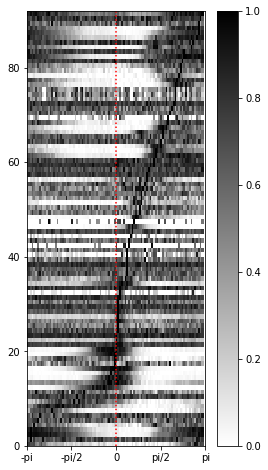

In [61]:

f = plt.figure(figsize=(4,8))
plt.pcolormesh(theta_k[:-1],np.arange(len(neuron_list)),normed_rate[order,:],
              cmap='gray_r')
plt.axvline(0,c='r',ls=':')
plt.xticks([-np.pi, -np.pi/2,0,np.pi/2,np.pi])
plt.gca().set_xticklabels(['-pi','-pi/2','0','pi/2','pi'])
plt.colorbar()

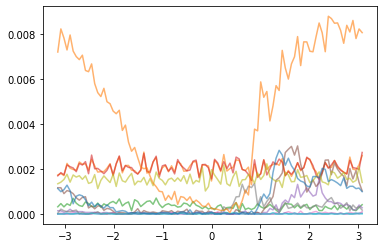

In [63]:
for ii in np.arange(30,90,5):
    plt.plot(theta_k[:-1],all_rate[ii],alpha=.6)

In [64]:
all_theta = []
all_L = []
for rate in all_rate:
    theta,L = postproc.get_PD_from_hist(theta_k[:-1],rate)
    all_theta.append(theta)
    all_L.append(L)
all_theta = np.array(all_theta)
all_L = np.array(all_L)

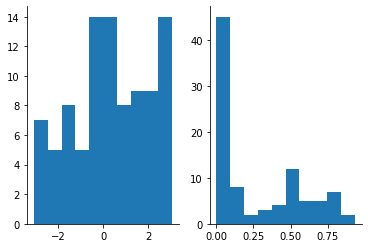

In [65]:
f,ax = plt.subplots(nrows=1,ncols=2)
ax[0].hist(all_theta)
ax[1].hist(all_L)
sns.despine();

In [66]:
df = pd.DataFrame()
df['sig'] = all_L>0.05
df['all_L'] = all_L
df['phi_pref'] = all_theta
df['depth'] = df_good.depth.values
df_sig = df[df.sig]
df_notsig = df[df.sig==False]
order = df_sig.sort_values('phi_pref').index
order_r = df_notsig.sort_values('phi_pref').index

In [67]:
df

,sig,all_L,phi_pref,depth
0,False,0.025131,0.498797,80.0
1,True,0.519314,0.918635,140.0
2,False,0.002729,0.922617,180.0
3,False,0.013175,1.501347,180.0
4,False,0.005896,2.168263,260.0
...,...,...,...,...
88,False,0.019347,0.064169,3020.0
89,False,0.008303,2.171876,3080.0
90,False,0.001430,2.602708,3600.0
91,False,0.006390,-1.090534,3600.0


WARNING    <ipython-input-68-487fe16bc016>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(theta_k[:-1],np.arange(len(order)),all_rate[order,:],
 [py.warnings]


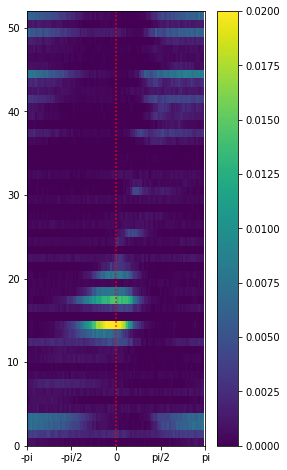

In [68]:
f = plt.figure(figsize=(4,8))
plt.pcolormesh(theta_k[:-1],np.arange(len(order)),all_rate[order,:],
              cmap='viridis',vmax=0.02)
plt.axvline(0,c='r',ls=':')
plt.xticks([-np.pi, -np.pi/2,0,np.pi/2,np.pi])
plt.gca().set_xticklabels(['-pi','-pi/2','0','pi/2','pi'])
plt.colorbar()

In [69]:
from statsmodels.nonparametric.smoothers_lowess import lowess
xx = df.sort_values('depth')['depth'].values
yy= lowess(df['all_L'].values,xx,frac=0.15,return_sorted=False)

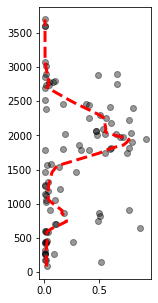

In [70]:
plt.figure(figsize=(2,5))
plt.plot(df['all_L'],df["depth"],'ko',alpha=0.4)
plt.plot(yy,xx,'r--',lw=3)

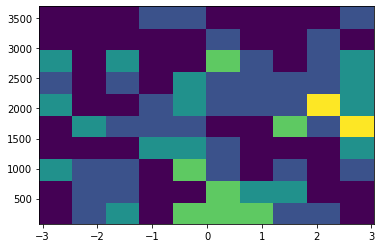

In [71]:

dff = df.dropna()
plt.hist2d(dff['phi_pref'],dff.depth);